### Imports

In [1]:
from qbo import QBO
from qmc import QMC
import numpy as np
import pandas as pd
from qiskit_aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeWashington
import matplotlib.pyplot as plt

import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import warnings
import seaborn as sns

### Download data

In [2]:
data = yf.download("JPY=X", start="2023-01-01", end="2025-01-01")
historical_data = pd.DataFrame(data)
historical_data.to_csv("data/usdjpy.csv")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
historical_data.head()

Price,Close,High,Low,Open,Volume
Ticker,JPY=X,JPY=X,JPY=X,JPY=X,JPY=X
Date,,,,,
2023-01-02,130.845001,131.035004,130.621002,130.845001,0
2023-01-03,130.794006,131.182007,129.533997,130.794006,0
2023-01-04,131.248001,132.169998,129.964005,131.248001,0
2023-01-05,132.246002,133.992004,131.729996,132.246002,0
2023-01-06,133.307007,134.740997,132.186996,133.307007,0


Text(0.5, 1.0, 'USD/JPY Close')

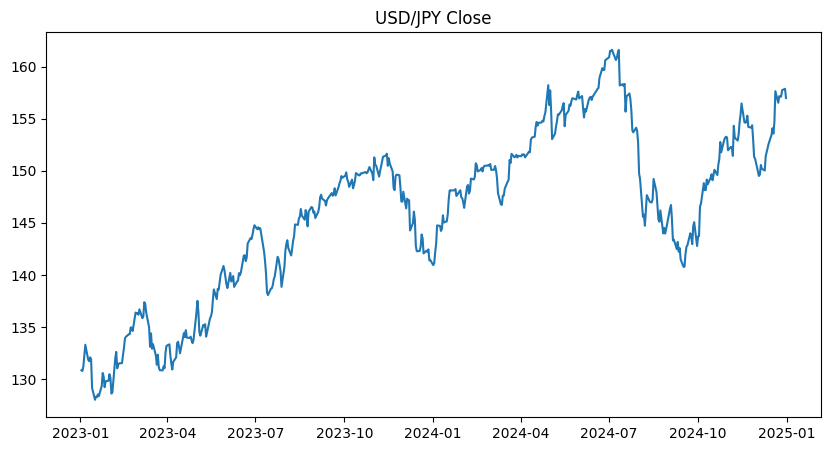

In [4]:
# Display closing price
# This is non-linear, non-stationary. Models WILL struggle to define relationships. Future datapoints could make gradients unstable
f = plt.figure(figsize=(10, 5))
plt.plot(historical_data["Close"].index, historical_data["Close"])
plt.title("USD/JPY Close")

Text(0.5, 1.0, 'USD/JPY Log-Return')

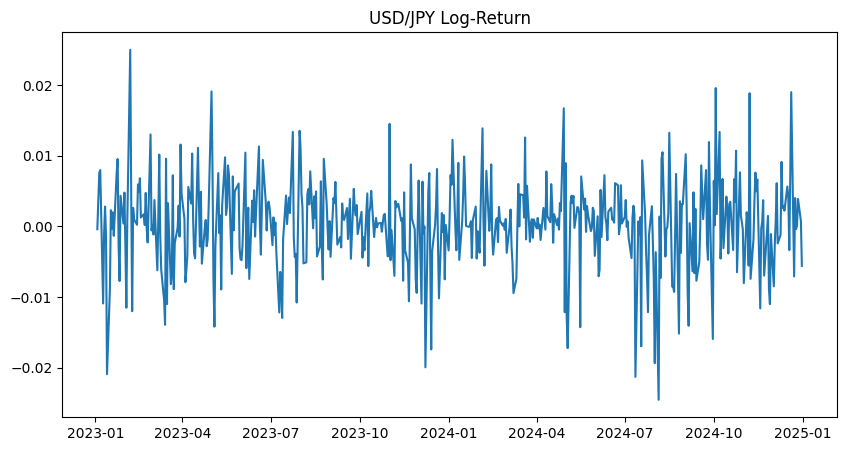

In [5]:
# Here, we compute the log returns. This allows the data to now be stationary
# This also creates a form of normalization, stabilizing gradients for future inputs
f = plt.figure(figsize=(10, 5))
y = np.log(historical_data["Close"].to_numpy()).squeeze()
y_delta = y[1:] - y[:-1]

plt.plot(historical_data["Close"].index[1:], y_delta)
plt.title("USD/JPY Log-Return")

### Experiment Config

In [6]:
# Quantum simulation device
device = FakeWashington()
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)

# Quantum params
quantum_noise = False
max_iter = 1000 # 11s for 100, 10min on 5000 for experiment
total_runs = 5
uncertainty_dim = 3 # number of qubits to use (exponentially increases runtime) 6 is default

In [7]:
# Lookahead prior sampling
dim1 = np.linspace(0, 1, 3) # add these alongside prior domain. treat as arb gridspace
dim2 = np.linspace(0, 1, 3)
dim3 = np.linspace(0, 1, 3)
dim = 3
domain = []
for a in dim1:
    for b in dim2:
        for c in dim3:
            domain.append([a, b, c])
domain = np.array(domain)
ls = np.array([0.2] * dim) # length scale
v_kernel = 0.5
obs_noise = 0.05 ** 2
M_target = 200

# RBF kernel
s = np.random.multivariate_normal(np.zeros(dim), 1 / (ls ** 2) * np.identity(dim), M_target)
b = np.random.uniform(0, 2 * np.pi, M_target)

fourier_features = {
    "s": s, # frequencies
    "b": b, # phases
    "v_kernel": v_kernel,
    "obs_noise": obs_noise,
    "domain": domain
}

pbounds = {}
for i in range(dim):
    pbounds["x" + str(i+1)] = (0, 1)

ts = np.arange(1, max_iter)
beta_t = 1 + np.sqrt(np.log(ts) ** 2)

### Train and Test Datasets

In [8]:
# Train-Test data
split = 0.7
train = np.log(historical_data["Close"].to_numpy()[0: int(len(historical_data) * split)]).squeeze()
test = np.log(historical_data["Close"].to_numpy()[int(len(historical_data) * split):]).squeeze()

train = train[1:] - train[:-1]
test = test[1:] - test[:-1]

### QMC Circuit

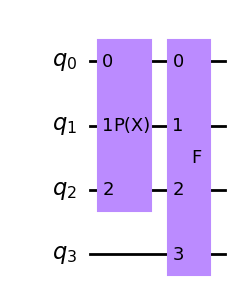

In [9]:
dummy_qmc = QMC(num_uncertainty=uncertainty_dim, means=1.0)
dummy_qmc.mc_circuit.draw(output="mpl")

In [10]:
model = ARIMA(train, order=(1, 2, 1))
model_fit = model.fit()
preds = model_fit.forecast(steps=len(test))

In [11]:
mape = (1. / len(test)) * np.sum(np.abs(test - preds) / preds)
inv_mape = 1. - (mape / 100.0)
print(inv_mape)

0.9774558539638015


### Model Priors and Train-Test Loop

In [12]:
def reward_function(param, eps, obs_noise):
    # Define priors (vary these)
    parameter_range = [[0.0, 2.0], [0.0, 2.0], [0.0, 2.0]]
    p = int(param[0] * (parameter_range[0][1] - parameter_range[0][0]) + parameter_range[0][0])
    d = int(param[1] * (parameter_range[1][1] - parameter_range[1][0]) + parameter_range[1][0])
    q = int(param[2] * (parameter_range[2][1] - parameter_range[2][0]) + parameter_range[2][0])

    # Train and estimate
    try:
        # Fit model
        model = ARIMA(train, order=(p, d, q))
        model_fit = model.fit()
        
        # Out of sample error
        preds = model_fit.forecast(steps=len(test))
        
        # Compute Inverse Mean Absolute Percent Error as loss. We choose inverse for maximization. Closer to 1 is better
        mape = (1. / len(test)) * np.sum(np.abs(test - preds) / preds)
        inv_mape = np.abs(1. - (mape / 100.0))
        if inv_mape > 1:
            inv_mape = 0
        
    except Warning:
        inv_mape = 0.0
    
    # Update beliefs via QBO and QMC
    qmc = QMC(num_uncertainty=uncertainty_dim, means=inv_mape, obs_noise=obs_noise)
    result, queries = qmc.estimate(eps)
    return result.estimation_processed, inv_mape, queries

### Apply QBO with Q-LinUCB (phase out, replace with classical BO)

In [13]:
warnings.simplefilter("error", ConvergenceWarning)
warnings.simplefilter("error", UserWarning)
quantum_BO = None
linear = True
all_lin_res = []
for itr in range(total_runs):
    print("Optimization Round", itr + 1)
    np.random.seed(itr)

    quantum_BO = QBO(
        reward_func=reward_function,
        pbounds=pbounds,
        beta_t=beta_t,
        random_features=fourier_features,
        bandits=linear,
        domain=domain
    )
    quantum_BO.maximize(n_iter=max_iter, init_points=1)
    all_lin_res.append(quantum_BO.res)

Optimization Round 1
Shot 0 ------ x_t: [1. 0. 1.], y_t: 0.006182042846131053
Shot 1 ------ x_t: [1. 0. 1.], y_t: 0.8939459865096939
Shot 2 ------ x_t: [1. 0. 1.], y_t: 0.8939459865096939
Shot 3 ------ x_t: [1. 0. 1.], y_t: 0.8939459865096939
Shot 4 ------ x_t: [1. 0. 1.], y_t: 0.8939459865096939
Shot 5 ------ x_t: [1. 0. 1.], y_t: 0.8939459865096939
Shot 6 ------ x_t: [1. 0. 1.], y_t: 0.8939459865096939
Shot 7 ------ x_t: [1. 0. 1.], y_t: 0.8939459865096939
Shot 8 ------ x_t: [1. 0. 1.], y_t: 0.8939459865096939
Shot 9 ------ x_t: [1. 0. 1.], y_t: 0.8939459865096939
Shot 10 ------ x_t: [1. 0. 1.], y_t: 0.8939459865096939
Shot 11 ------ x_t: [1. 0. 1.], y_t: 0.8939459865096939
Shot 12 ------ x_t: [1. 0. 1.], y_t: 0.8939459865096939
Shot 13 ------ x_t: [1. 0. 1.], y_t: 0.8939459865096939
Shot 14 ------ x_t: [1. 0. 1.], y_t: 0.8939459865096939
Shot 15 ------ x_t: [1. 0. 1.], y_t: 0.8939459865096939
Shot 16 ------ x_t: [1. 0. 1.], y_t: 0.8939459865096939
Shot 17 ------ x_t: [1. 0. 1.], y_t

### Apply QBO with Q-GP-UCB

Please note, output params are squashed in the sampling domain space (between 0 and 1).  
To see the true parameter value, you must rescale to the parameter bounds

In [14]:
quantum_BO = None
linear = False
all_gp_res = []
for itr in range(total_runs):
    print("Optimization Round", itr + 1)
    np.random.seed(itr)

    quantum_BO = QBO(
        reward_func=reward_function,
        pbounds=pbounds,
        beta_t=beta_t,
        random_features=fourier_features,
        bandits=linear,
        domain=domain
    )
    quantum_BO.maximize(n_iter=max_iter, init_points=1)
    all_gp_res.append(quantum_BO.res)

Optimization Round 1
Shot 0 ------ x_t: [1.  0.5 1. ], y_t: 0.9444289393453084
Shot 1 ------ x_t: [1.  0.5 1. ], y_t: 0.9444289393453084
Shot 2 ------ x_t: [1.  0.5 1. ], y_t: 0.9444289393453084
Shot 3 ------ x_t: [1.  0.5 1. ], y_t: 0.9444289393453084
Shot 4 ------ x_t: [1.  0.5 1. ], y_t: 0.9444289393453084
Shot 5 ------ x_t: [1.  0.5 1. ], y_t: 0.9444289393453084
Shot 6 ------ x_t: [1.  0.5 1. ], y_t: 0.9444289393453084
Shot 7 ------ x_t: [1.  0.5 1. ], y_t: 0.9478671611362975
Shot 8 ------ x_t: [1.  0.5 1. ], y_t: 0.9453767009689261
Shot 9 ------ x_t: [1.  0.5 1. ], y_t: 0.9429238535877531
Shot 10 ------ x_t: [1.  0.5 1. ], y_t: 0.9439229606199429
Shot 11 ------ x_t: [1.  0.5 1. ], y_t: 0.9424935215475927
Shot 12 ------ x_t: [1.  0.5 1. ], y_t: 0.9392051079292969
Shot 13 ------ x_t: [1.  0.5 1. ], y_t: 0.9394155931014281
Shot 14 ------ x_t: [1.  0.5 1. ], y_t: 0.9396155352049052
Optimization Round 2
Shot 0 ------ x_t: [0.5 0.5 0. ], y_t: 0.9719556124895262
Shot 1 ------ x_t: [0.5 0

### Param Distribution

In [15]:
# Retrieve collective param results. Rescale
parameter_range = [0.0, 2.0] # unique for this, since all params have same range

# Individual param distributions
x1_dist = {k: 0 for k in range(3)}
x2_dist = {k: 0 for k in range(3)}
x3_dist = {k: 0 for k in range(3)}
for gp_res in all_gp_res:
    for param in gp_res["all"]["params"]:
        # Rescale
        param = (param * (parameter_range[1] - parameter_range[0]) + parameter_range[0]).astype("int")
        # Frequencies
        x1, x2, x3 = param
        for xn, dist in zip([x1, x2, x3], [x1_dist, x2_dist, x3_dist]):
            dist[xn] += 1

# Relational param distribution
param_dist = {}
for gp_res in all_gp_res:
    for param in gp_res["all"]["params"]:
        # Rescale
        param = (param * (parameter_range[1] - parameter_range[0]) + parameter_range[0]).astype("int")
        # Frequencies
        param = tuple(param.tolist())
        if param not in param_dist:
            param_dist[param] = 0
        param_dist[param] += 1
    
print(x1_dist)
print(x2_dist)
print(x3_dist)
print(param_dist)

{0: 15, 1: 45, 2: 16}
{0: 14, 1: 61, 2: 1}
{0: 30, 1: 31, 2: 15}
{(2, 1, 2): 15, (1, 1, 0): 30, (1, 0, 1): 14, (1, 1, 1): 1, (2, 2, 1): 1, (0, 1, 1): 15}


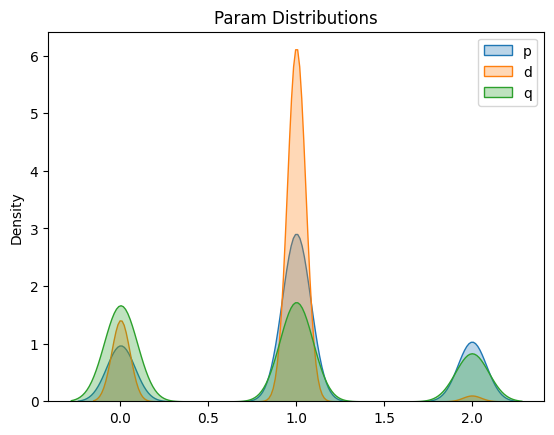

In [16]:
# Extract frequencies
x1_samples = []
x2_samples = []
x3_samples = []    
for value, freq in x1_dist.items():
    x1_samples.extend([value] * freq)
for value, freq in x2_dist.items():
    x2_samples.extend([value] * freq)
for value, freq in x3_dist.items():
    x3_samples.extend([value] * freq)

# KDE plot
sns.kdeplot(x1_samples, bw_adjust=0.3, fill=True, label="p", alpha=0.3)
sns.kdeplot(x2_samples, bw_adjust=0.3, fill=True, label="d", alpha=0.3)
sns.kdeplot(x3_samples, bw_adjust=0.3, fill=True, label="q", alpha=0.3)

# Axis labels
plt.title("Param Distributions")
plt.legend()

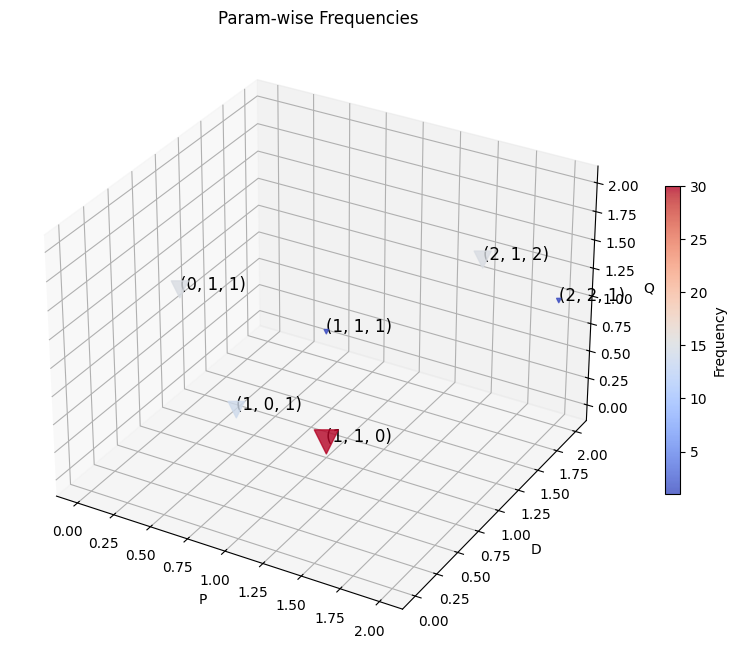

In [17]:
# Extract coordinates and frequencies
x = [key[0] for key in param_dist]
y = [key[1] for key in param_dist]
z = [key[2] for key in param_dist]
freq = list(param_dist.values())

# Set up 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Use frequency as size or color
scatter = ax.scatter(x, y, z, c=freq, s=[f * 10 for f in freq], cmap='coolwarm', alpha=0.8, marker="v")

# Annotate each point with its coordinates
for xi, yi, zi in zip(x, y, z):
    ax.text(xi, yi, zi, f'({xi}, {yi}, {zi})', size=12, zorder=1, color='black')

# Colorbar to show frequency scale
cbar = plt.colorbar(scatter, ax=ax, shrink=0.5)
cbar.set_label('Frequency')

# Axis labels
ax.set_xlabel('P')
ax.set_ylabel('D')
ax.set_zlabel('Q')
ax.set_title('Param-wise Frequencies')

plt.show()

### True Best Params

In [18]:
parameter_range = [0.0, 2.0] # unique for this, since all params have same range
max_params = {}
for gp_res in all_gp_res:
    val, params = gp_res["max"]["max_val"], gp_res["max"]["max_params"]
    params = [(p * (parameter_range[1] - parameter_range[0]) + parameter_range[0]).astype("int") for p in params.values()]
    max_params[val] = params

best_params = max_params[max(max_params.keys())]
print("Confidence:", max(max_params.keys()))
print("Params (p, d, q):", best_params)

Confidence: 0.9764970929042371
Params (p, d, q): [1, 1, 0]


In [19]:
model = ARIMA(train, order=tuple(best_params))
model_fit = model.fit()
in_sample = model_fit.predict()
out_sample = model_fit.forecast(steps=len(test))

print(in_sample.shape)
print(out_sample.shape)

(364,)
(156,)


Text(0.5, 1.0, 'In Sample USD/JPY Log-Return')

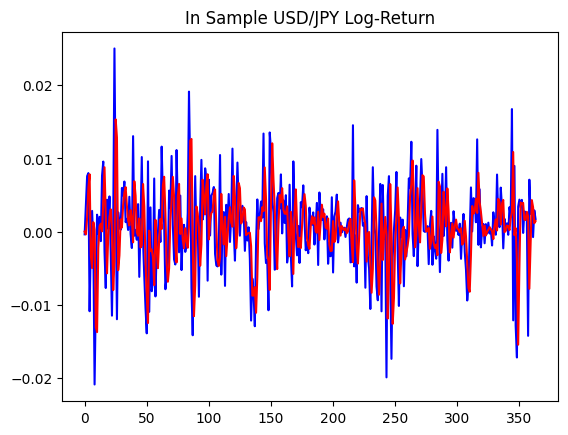

In [20]:
plt.plot(np.arange(len(train)), train, color="blue")
plt.plot(np.arange(len(in_sample)), in_sample, color="red")
plt.title("In Sample USD/JPY Log-Return")

Text(0.5, 1.0, 'Out of Sample USD/JPY Log-Return')

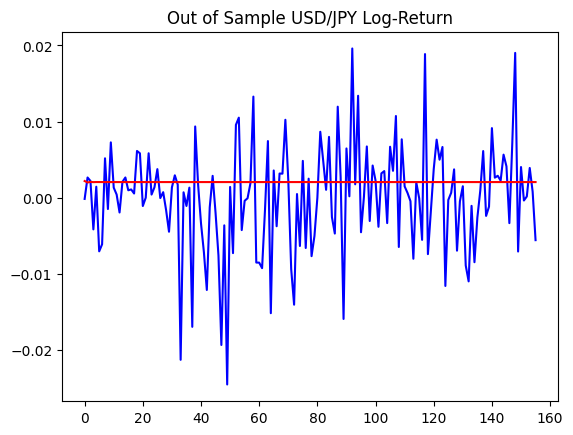

In [21]:
plt.plot(np.arange(len(test)), test, color="blue")
plt.plot(np.arange(len(out_sample)), out_sample, color="red")
plt.title("Out of Sample USD/JPY Log-Return")

### Cumulative Regret

In [22]:
# Norm const
f_max = 0
for i in range(total_runs):
    gp_fvalues = all_gp_res[i]["all"]["f_values"]
    lin_fvalues = all_lin_res[i]["all"]["f_values"]
    f_max = max(f_max, max(gp_fvalues), max(lin_fvalues))

In [23]:
# Collect total cumulative regrets
all_gp_regrets = []
all_lin_regrets = []
min_sims = max_iter
for gp_res, lin_res in zip(all_gp_res, all_lin_res):
    gp_values = gp_res["all"]["f_values"]
    gp_queries = gp_res["all"]["track_queries"]
    lin_values = lin_res["all"]["f_values"]
    lin_queries = lin_res["all"]["track_queries"]
    
    gp_values_new = []
    lin_values_new = []
    for i in range(len(gp_values)):
        gp_values_new += list(np.repeat(gp_values[i], gp_queries[i]))
    for i in range(len(lin_values)):
        lin_values_new += list(np.repeat(lin_values[i], lin_queries[i]))
    
    gp_values = np.squeeze(f_max - np.array(gp_values_new))
    lin_values = np.squeeze(f_max - np.array(lin_values_new))
    gp_values_acc = np.cumsum(gp_values)
    lin_values_acc = np.cumsum(lin_values)
    
    min_sims = min(min_sims, len(gp_values_acc))
    min_sims = min(min_sims, len(lin_values_acc))
    
    all_gp_regrets.append(gp_values_acc)
    all_lin_regrets.append(lin_values_acc)

all_gp_regrets = np.array([a[:min_sims] for a in all_gp_regrets])
all_lin_regrets = np.array([a[:min_sims] for a in all_lin_regrets])

In [24]:
# Compute means and confidence range
all_gp_regrets_mean = np.mean(all_gp_regrets, axis=0)
all_lin_regrets_mean = np.mean(all_lin_regrets, axis=0)

all_gp_regrets_stderr = np.std(all_gp_regrets, axis=0) / (np.sqrt(len(all_gp_regrets)))
all_lin_regrets_stderr = np.std(all_lin_regrets, axis=0) / (np.sqrt(len(all_lin_regrets)))

all_gp_regrets_ub = all_gp_regrets_mean + all_gp_regrets_stderr
all_gp_regrets_lb = all_gp_regrets_mean - all_gp_regrets_stderr
all_lin_regrets_ub = all_lin_regrets_mean + all_lin_regrets_stderr
all_lin_regrets_lb = all_lin_regrets_mean - all_lin_regrets_stderr

In [25]:
print(all_gp_regrets_mean.shape)
print(all_lin_regrets_mean.shape)

(1000,)
(1000,)


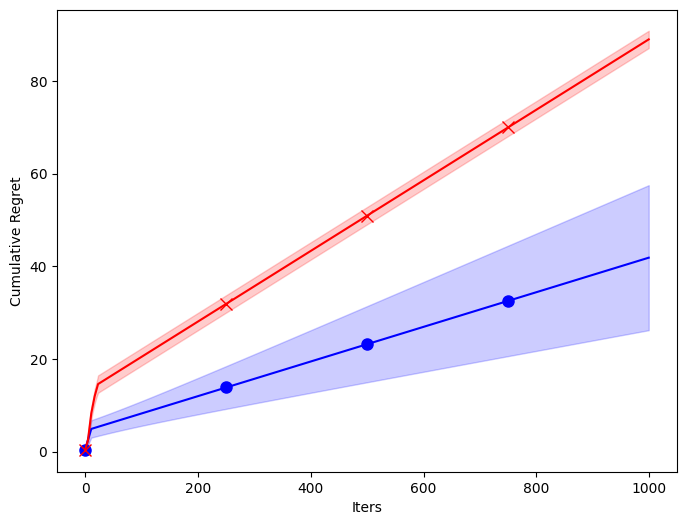

In [26]:
# Init figure
plt.figure(figsize=(8, 6))
ts = np.arange(0, min_sims)

# Plot Q-GP-UCB regrets
plt.fill_between(ts, all_gp_regrets_ub, all_gp_regrets_lb, color="b", alpha=0.2)
plt.plot(ts, all_gp_regrets_mean, "b", marker="o", markersize=8, markevery=250)

# Plot Q-LIN-UCB regrets (will be removed)
plt.fill_between(ts, all_lin_regrets_ub, all_lin_regrets_lb, color="r", alpha=0.2)
plt.plot(ts, all_lin_regrets_mean, "r", marker="x", markersize=8, markevery=250)

# Axis labels
plt.ylabel("Cumulative Regret")
plt.xlabel("Iters")
plt.show()